In [1]:
# pip install -r requirements.txt --trusted-host pypi.org --trusted-host files.pythonhosted.org

In [2]:
import re
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score
from tokenizers import ByteLevelBPETokenizer
from tokenizers.pre_tokenizers import Whitespace
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

sys.path.insert(0, '../model')
sys.path.insert(0, '../modules')
from h2i_01_lstm import H2I01LSTM
from custom_dataset import CustomDataset

In [3]:
data_train = pd.read_csv('./data/h2i_01_asset_type_train.csv')
data_valid = pd.read_csv('./data/h2i_01_asset_type_valid.csv')
data_test = pd.read_csv('./data/h2i_01_asset_type_test.csv')

In [4]:
tokenizer = ByteLevelBPETokenizer()
tokenizer.pre_tokenizer = Whitespace()

tokenizer.enable_padding(pad_id=0, pad_token='<pad>')

In [5]:
texts = [text.lower() for text in list(data_train['text'])]

In [6]:
with open('texts.txt', 'w') as f:
    for text in texts:
        f.write("%s\n" % text)

In [7]:
tokenizer.train(
    files=['texts.txt'],
    vocab_size=3_000,
    min_frequency=2,
    special_tokens=['<pad>', '<unk>']
    )

In [8]:
tokenizer.save('tokenizer.json')

In [9]:
tokens_list = [tokenizer.encode(text).ids for text in texts]

In [10]:
data_train['tokens'] = tokens_list 

In [11]:
len_list = [len(tokens) for tokens in list(data_train['tokens'])]

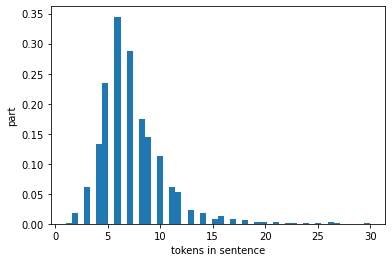

In [12]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(len_list, density=True, bins=50)
plt.ylabel('part')
plt.xlabel('tokens in sentence');

In [13]:
max_len = 16

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):

    def __init__(self, tokens, labels, max_len):
        self.tokens = tokens
        self.labels = labels
        self.max_len = max_len


    def __len__(self):
        return len(self.tokens)


    def __getitem__(self, idx):
        label = self.labels[idx]
        label = torch.tensor(label)
        tokens = self.tokens[idx]
        out = torch.zeros(self.max_len, dtype=torch.long)
        out[:len(tokens)] = torch.tensor(tokens, dtype=torch.long)[:self.max_len]
        return out, label

In [15]:
import torch
import torch.nn as nn


class NeuralNetwork(nn.Module):


    def __init__(self, hidden_dim=128, vocab_size=3000, embedding_dim=300, linear_dim=128, dropout=0.3, n_classes=2):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.lstm_layer2 = nn.LSTM(hidden_dim*2, hidden_dim, batch_first=True, bidirectional=True)
        self.lstm_layer3 = nn.LSTM(hidden_dim*2, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(dropout)        
        self.fc_layer = nn.Linear(hidden_dim * 2, linear_dim)
        self.fc_layer2 = nn.Linear(linear_dim, linear_dim)
        self.batchnorm = nn.BatchNorm1d(linear_dim)
        self.relu = nn.ReLU()
        self.out_layer = nn.Linear(linear_dim, n_classes)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, inputs):
        batch_size = inputs.size(0)
        embeddings = self.embedding_layer(inputs)
        lstm_out, (ht, ct) = self.lstm_layer(embeddings)
#         lstm_out, (ht, ct) = self.lstm_layer2(lstm_out, (ht, ct))
#         lstm_out, (ht, ct) = self.lstm_layer3(lstm_out, (ht, ct))
        out = ht.transpose(0, 1)
        out = out.reshape(batch_size, -1)
        out = self.fc_layer(out)
        out = self.batchnorm(out)
        out = self.relu(out)
#         out = self.fc_layer2(out)
#         out = self.batchnorm(out)
#         out = self.relu(out)
        out = self.dropout_layer(out)
        out = self.out_layer(out)
        out = torch.squeeze(out, 1)
        out = torch.sigmoid(out)
#         out = self.softmax(out)
        return out

In [16]:
labels = list(data_train['label'])
train_dataset = CustomDataset(tokens_list, labels, max_len)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)

In [17]:
valid_texts = [text.lower() for text in list(data_valid['text'])]
valid_ids = [tokenizer.encode(text).ids for text in valid_texts]
valid_labels = list(data_valid['label'])
valid_dataset = CustomDataset(valid_ids, valid_labels, max_len)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=False)

In [18]:
test_texts = [text.lower() for text in list(data_test['text'])]
test_ids = [tokenizer.encode(text).ids for text in test_texts]
test_labels = list(data_test['label'])
test_dataset = CustomDataset(test_ids, test_labels, max_len)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [21]:
def eval_nn(model, data_loader):
    predicted = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            x = x.to(device)
            outputs = model(x)
            _, predict = torch.max(outputs.data, 1)
            predict = predict.cpu().detach().numpy().tolist()
            predicted += predict
            labels += y
        score = f1_score(labels, predicted, average='binary')
    return labels, predicted, score

In [22]:
def train_nn(model, optimizer, loss_function, train_loader, valid_loader, test_loader, device, epochs=10):
    best_score = 0
    for epoch in range(epochs):
        model.train()
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            predict = model(inputs)
            loss = loss_function(predict, labels)
            loss.backward()
            optimizer.step()
        _, _, score_valid = eval_nn(model, valid_loader)
        _, _, score_test = eval_nn(model, test_loader)
        print(epoch, round(score_valid, 3), round(score_test, 3))
        if score_valid > best_score:
#             torch.save(model,'h2i_01_asset_type_' + str(round(score_valid, 4)) + '.pt')
#             torch.save(model.state_dict(),'h2i_01_asset_type_dict_' + str(round(score_valid, 4)) + '.pt')
            best_score = score_valid
    return best_score

In [23]:
best_score = 0
loss_function = nn.CrossEntropyLoss().to(device)

model = NeuralNetwork(hidden_dim=256, vocab_size=3000, embedding_dim=300, linear_dim=256, dropout=0.1)
model.apply(init_weights)
model.to(device)
optimizer = optim.AdamW(model.parameters())
train_nn(model, optimizer, loss_function, train_loader, valid_loader, test_loader, device)        

  1%|          | 3/271 [00:00<00:10, 25.87it/s]

0 0.913 0.913


  1%|          | 3/271 [00:00<00:10, 25.92it/s]

1 0.914 0.91


  1%|          | 3/271 [00:00<00:10, 26.35it/s]

2 0.913 0.92


  1%|          | 3/271 [00:00<00:10, 25.93it/s]

3 0.919 0.902


  1%|          | 3/271 [00:00<00:10, 25.70it/s]

4 0.935 0.92


  1%|          | 3/271 [00:00<00:10, 25.82it/s]

5 0.925 0.909


  1%|          | 3/271 [00:00<00:10, 25.34it/s]

6 0.933 0.929


  1%|          | 3/271 [00:00<00:10, 25.36it/s]

7 0.919 0.925


  1%|          | 3/271 [00:00<00:10, 25.59it/s]

8 0.93 0.922


100%|██████████| 271/271 [00:11<00:00, 24.30it/s]


9 0.933 0.905


0.9352941176470588